# Read ASC files

## Import libraries

In [5]:
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio

## Ubicación de los archivos ASC

In [2]:
asc_files = glob.glob('data/Rasters/*/*.asc')
asc_files[:5]

['data/Rasters\\Hydraulic\\Depth____0.0.asc',
 'data/Rasters\\Hydraulic\\Depth____10200.0.asc',
 'data/Rasters\\Hydraulic\\Depth____10500.0.asc',
 'data/Rasters\\Hydraulic\\Depth____10800.0.asc',
 'data/Rasters\\Hydraulic\\Depth____11100.0.asc']

# Read SINGLE ASC file

In [11]:
asc_loc = r'data/Rasters\\Hydraulic\\Depth____0.0.asc'
raster = rio.open(asc_loc)
print(raster.crs)

None


In [12]:
grid = rio.open(asc_files[0])
grid.prj

AttributeError: 'DatasetReader' object has no attribute 'prj'

In [10]:
grid.xy

<bound method TransformMethodsMixin.xy of <open DatasetReader name='data/Rasters\Hydraulic\Depth____0.0.asc' mode='r'>>

In [9]:
ascii_grid = np.loadtxt(asc_files[0], skiprows=6)
null_value = -9999.
ascii_grid[ascii_grid == null_value] = np.nan
ascii_grid.shape

(1923, 1540)

In [10]:
ascii_grid

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

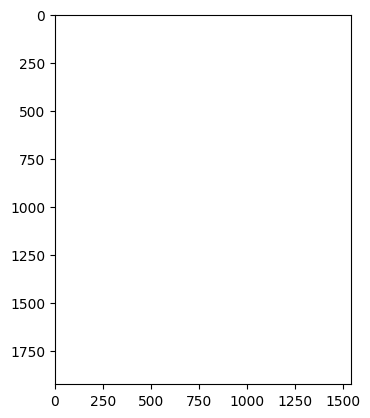

In [12]:
plt.imshow(ascii_grid)

# Read MULTIPLE ASC files